In [1]:
library(tidyverse)
library(tidygraph)
library(blur)
library(cowplot)

load("../../data/genesis/gi.net")
load("../../data/genesis/genesis.RData")
hyper <- read_delim("hyperparams.tsv", ";", col_types = "ccdd")

experiments <- list.dirs(recursive = F)
experiments <- gsub("./", "", experiments, fixed = T)
experiments <- experiments[lapply(experiments, nchar) == 30]

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘tidygraph’

The following object is masked from ‘package:stats’:

    filter


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# GENESIS

For reference, the parameters on the GENESIS dataset were eta = 2.38 and lambda = 102.12.

In [2]:
genesis_results <- read_tsv("../evo/cones.evo.chi2.consistency.additive.gi.tsv",
                            col_types = "ciiiccdli") %>%
    mutate(exp = "genesis", causal = NA)

# Consistency

In [3]:
cons <- lapply(experiments, function(e) {
    resfile <- list.files(path = e, pattern = "cones.evo.chi2.consistency.*", full.names = T)
    solfile <- list.files(path = e, pattern = "causal.RData", full.names = T)
    load(resfile)
    load(solfile)
    cones$exp <- e
    cones$causal <- causal
    cones
}) %>% do.call(rbind, .)

plotHyper <- filter(hyper, model_selection == "consistency") %>%
    ggplot(aes(x = log10(lambda), y = log10(eta))) +
        geom_hex() +
        labs(title = "Consistency") +
        theme_minimal()

Warning message:
“Removed 4836 rows containing non-finite values (stat_boxplot).”

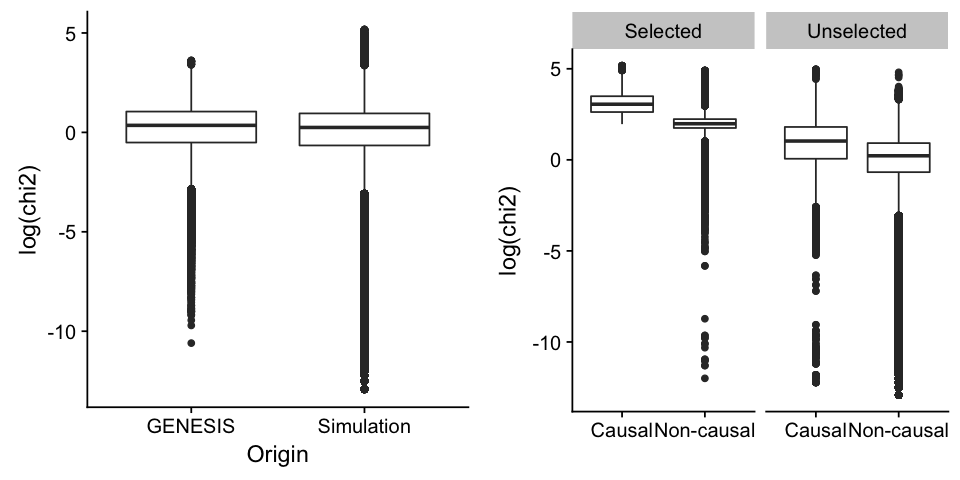

In [4]:
A <- rbind(genesis_results, cons) %>%
    ggplot(aes(x = ifelse(exp == "genesis", "GENESIS", "Simulation"), y = log(c))) + 
        geom_boxplot() +
        labs(x = "Origin", y = "log(chi2)")

B <- ggplot(cons, aes(x = ifelse(causal, "Causal", "Non-causal"), y = log(c))) + 
    geom_boxplot() +
    facet_grid(. ~ ifelse(selected, "Selected", "Unselected")) +
    labs(x = "", y = "log(chi2)")

options(repr.plot.width=8, repr.plot.height=4)
plot_grid(A, B)

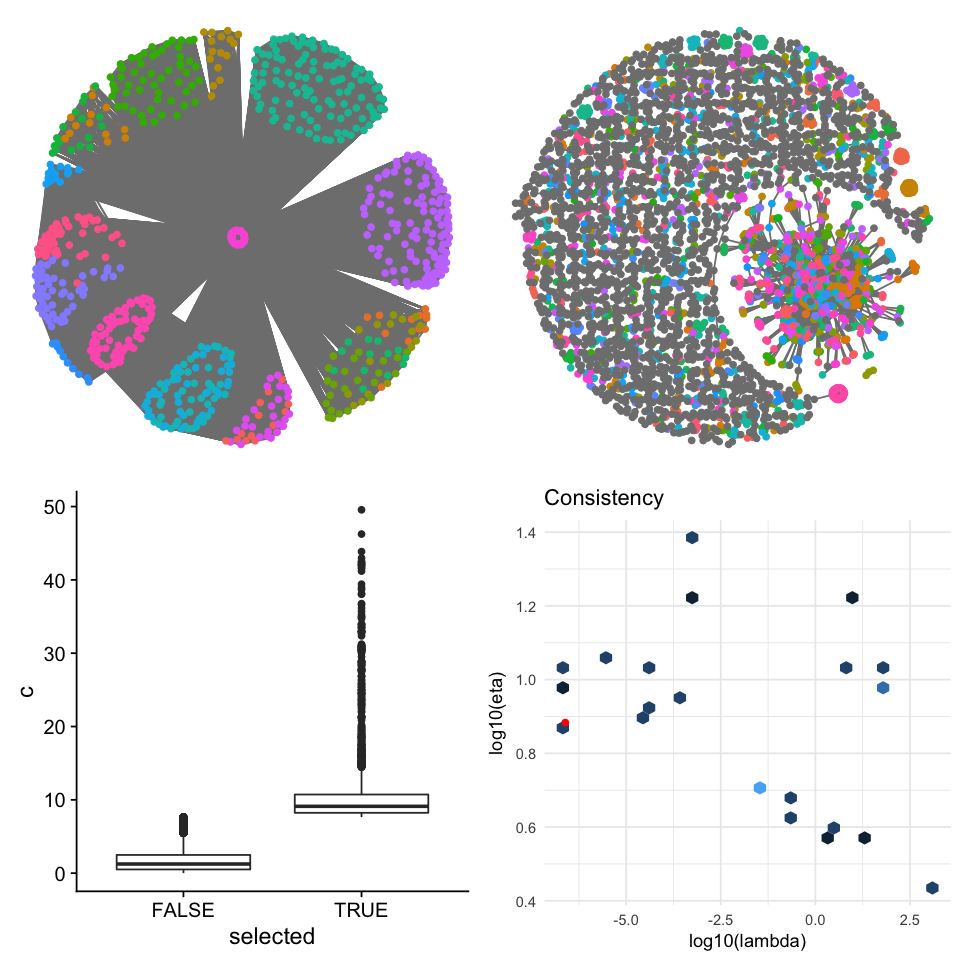

In [5]:
plot_subnets <- function(cones, net, e, s) {
    
    hy <- filter(hyper, model_selection == s & experiment == e)
    
    causal <- filter(cones, exp == e) %>%
        filter(causal) %>%
        .$snp %>%
        as.character %>%
        plot_subnetwork(genesis, net, .) +
            guides(color=FALSE)

    detected <- filter(cones, exp == e) %>%
        filter(selected) %>%
        .$snp %>%
        as.character %>%
        plot_subnetwork(genesis, net, .) +
            guides(color=FALSE)

    box <- filter(cones, exp == e) %>%
        ggplot(aes(x = selected, y = c)) +
        geom_boxplot()
    
    hyperplot <- plotHyper +
        geom_point(data = hy, aes(x=log10(lambda), y=log10(eta)), colour="red") +
        guides(fill=FALSE)

    plot_grid(causal, detected, box, hyperplot) %>% print

}

options(repr.plot.width=8, repr.plot.height=8)
e <- filter(hyper, lambda < 1e-6 & model_selection == "consistency")$experiment[1]
suppressMessages(plot_subnets(cons, net, e, "consistency"))

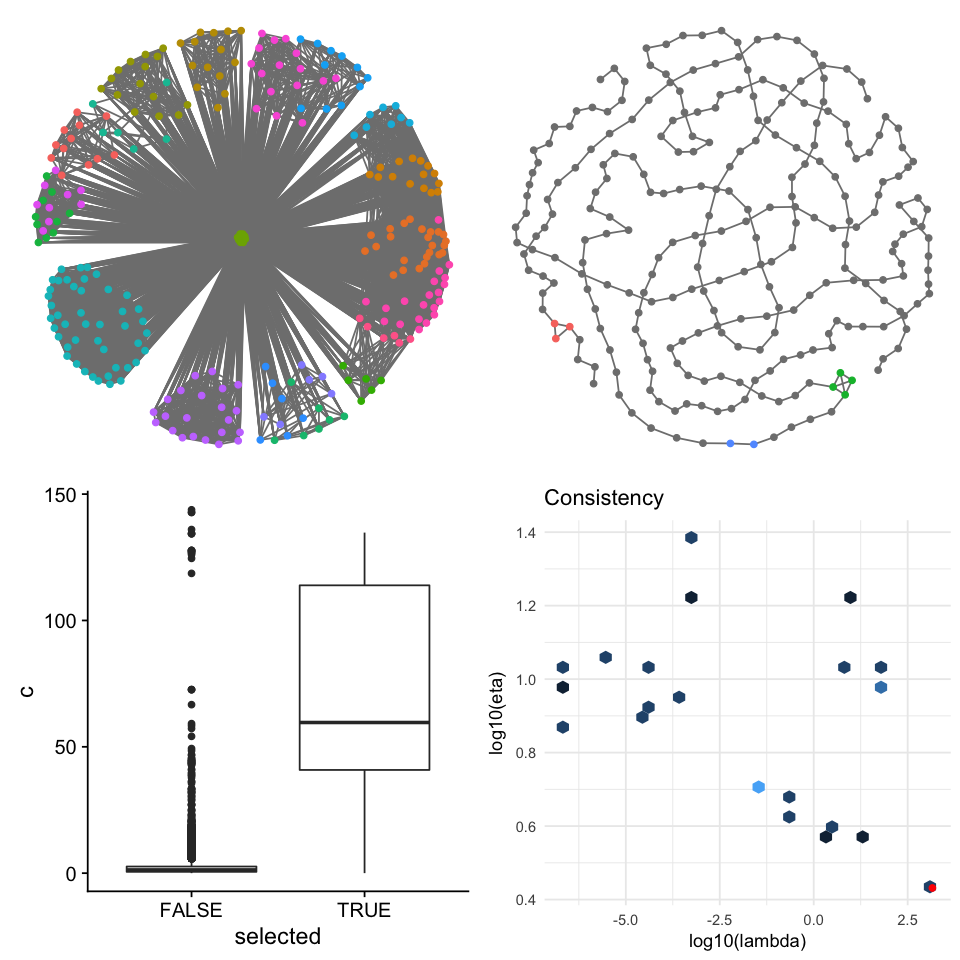

In [6]:
e <- filter(hyper, lambda > 1e2 & eta > 2 & model_selection == "consistency")$experiment[1]
plot_subnets(cons, net, e, "consistency")

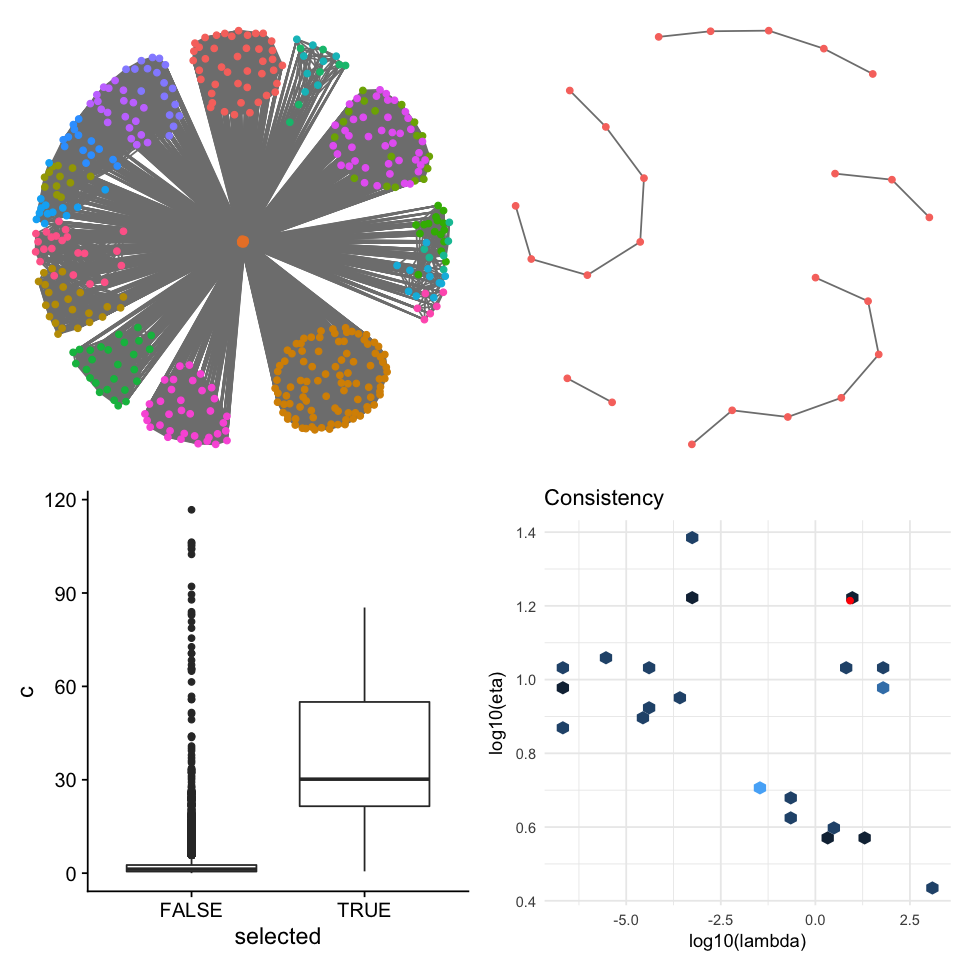

In [7]:
e <- filter(hyper, lambda > 1 & eta > 1 & model_selection == "consistency")$experiment[1]
plot_subnets(cons,  mutate(net, gene = ifelse(is.na(gene), "None", gene)), e, "consistency")

# BIC

In [8]:
bic <- lapply(experiments, function(e) {
    resfile <- list.files(path = e, pattern = "cones.evo.chi2.bic.*", full.names = T)
    solfile <- list.files(path = e, pattern = "causal.RData", full.names = T)
    load(resfile)
    load(solfile)
    cones$exp <- e
    cones$causal <- causal
    cones
}) %>% do.call(rbind, .)

plotHyper <- filter(hyper, model_selection == "bic") %>%
ggplot(aes(x = log10(lambda), y = log10(eta))) +
    geom_hex() +
    labs(title = "BIC") +
    theme_minimal()

Warning message:
“Removed 4836 rows containing non-finite values (stat_boxplot).”

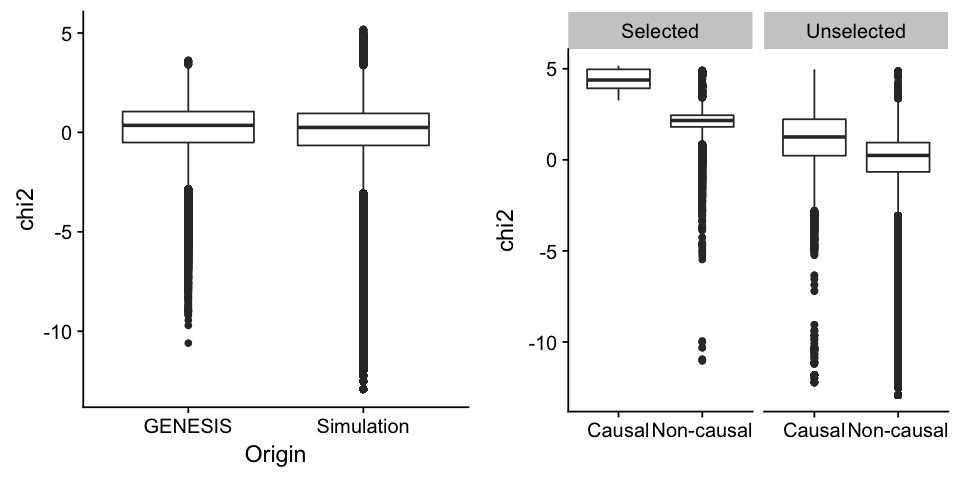

In [9]:
A <- rbind(genesis_results, bic) %>%
    ggplot(aes(x = ifelse(exp == "genesis", "GENESIS", "Simulation"), y = log(c))) + 
        geom_boxplot() +
        labs(x = "Origin", y = "chi2")

B <- ggplot(bic, aes(x = ifelse(causal, "Causal", "Non-causal"), y = log(c))) + 
    geom_boxplot() +
    facet_grid(. ~ ifelse(selected, "Selected", "Unselected")) +
    labs(x = "", y = "chi2")

options(repr.plot.width=8, repr.plot.height=4)
plot_grid(A, B)

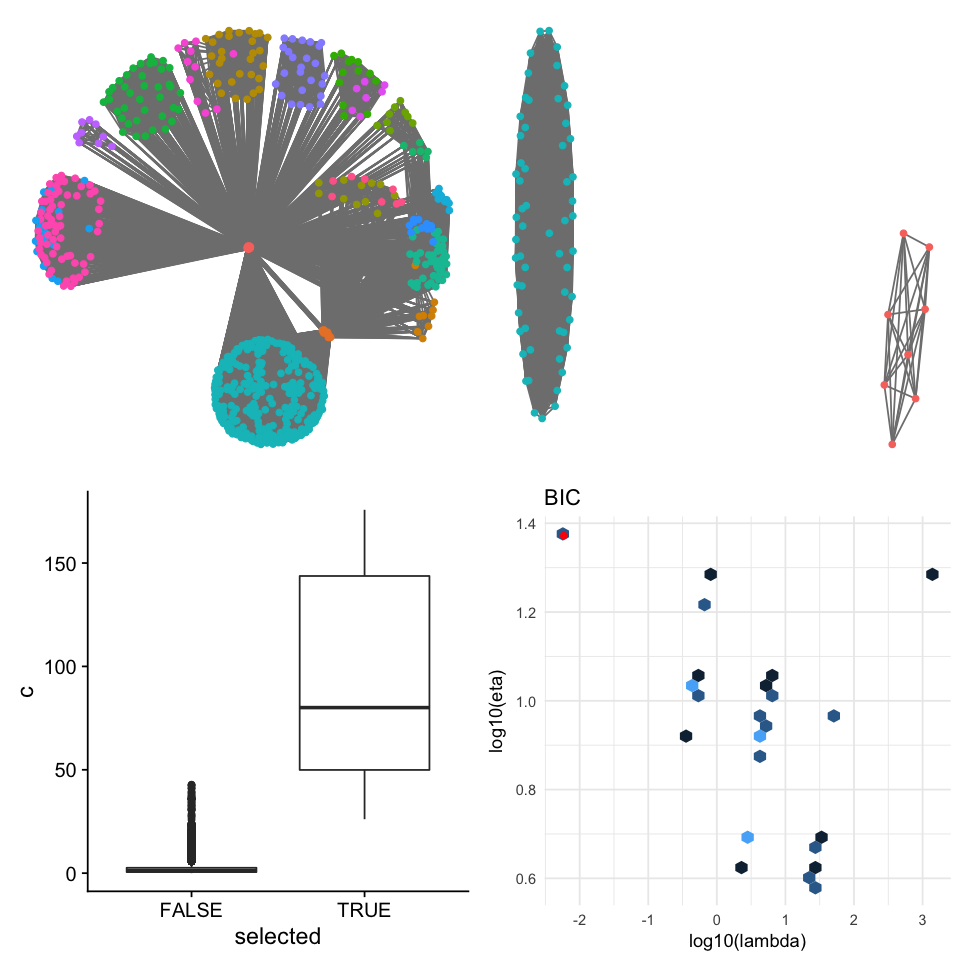

In [10]:
options(repr.plot.width=8, repr.plot.height=8)
e <- filter(hyper, lambda < 0.1 & model_selection == "bic")$experiment[1]
plot_subnets(bic, net, e, "bic")

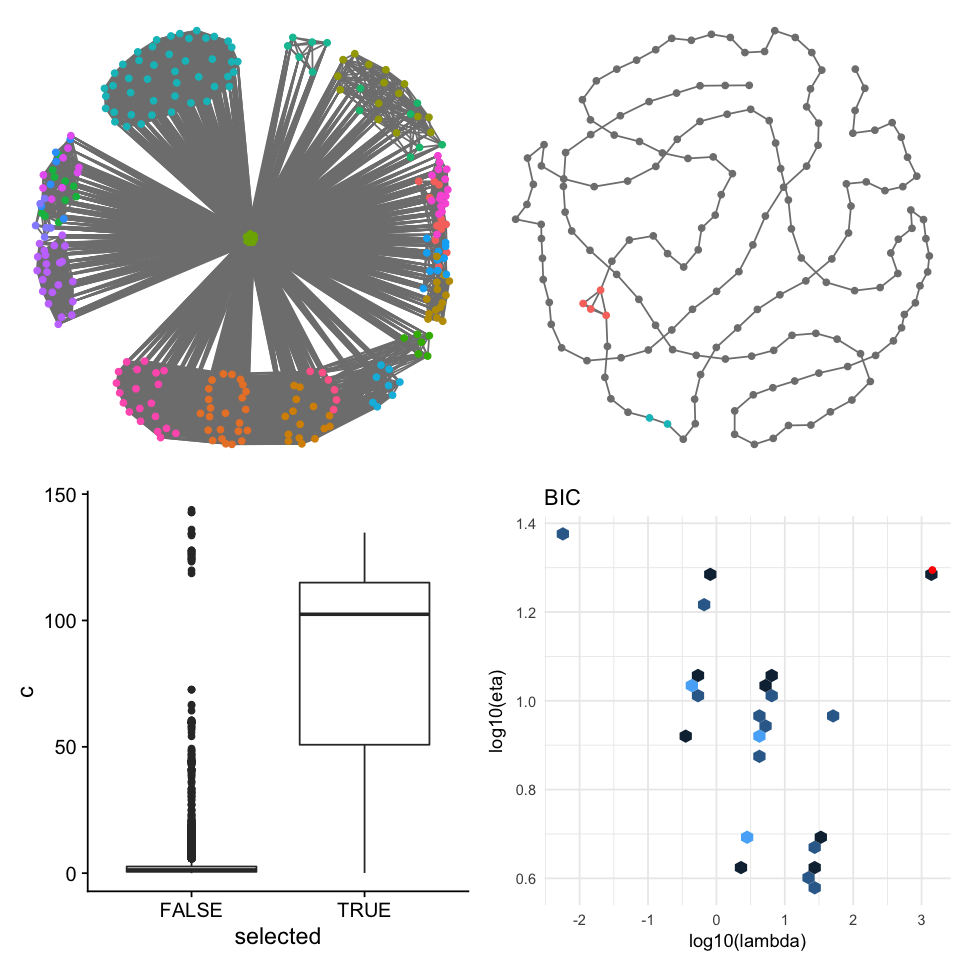

In [11]:
e <- filter(hyper, lambda > 1000 & model_selection == "bic")$experiment[1]
plot_subnets(bic, net, e, "bic")

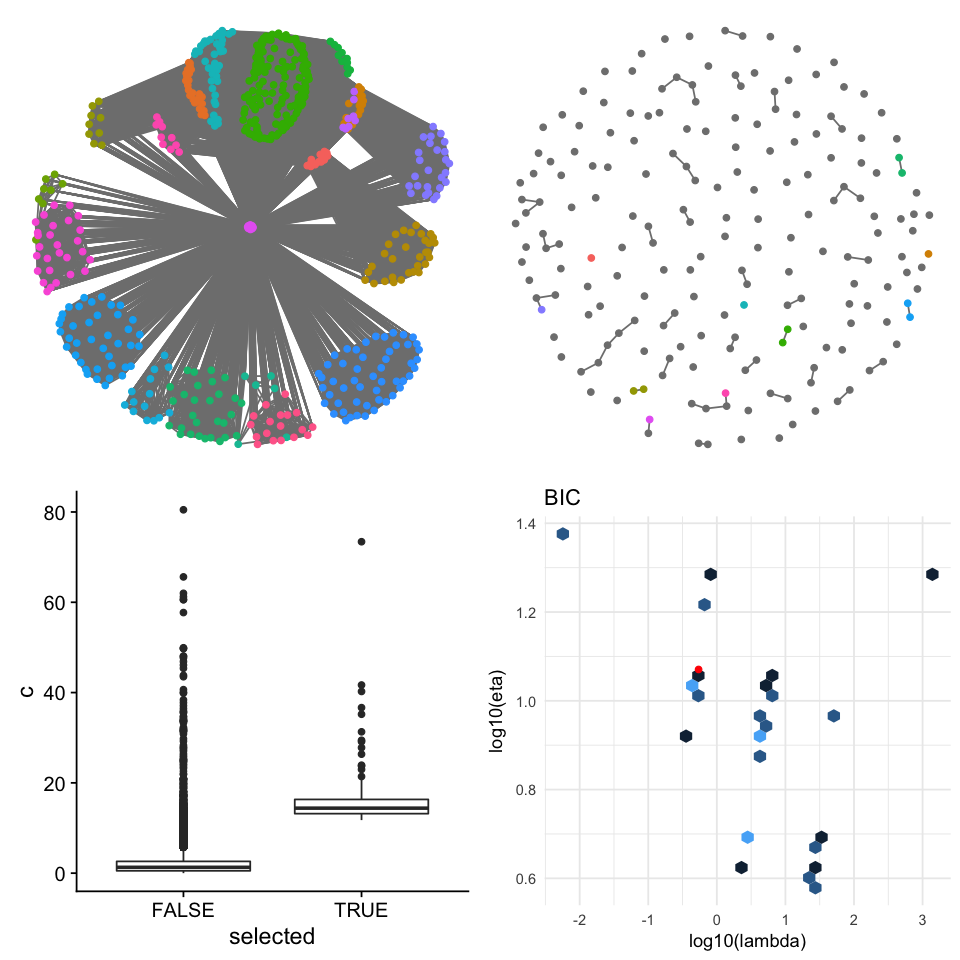

In [12]:
e <- filter(hyper, eta < 10^(1.2) & eta > 10 & model_selection == "bic")$experiment[1]
plot_subnets(bic, net, e, "bic")

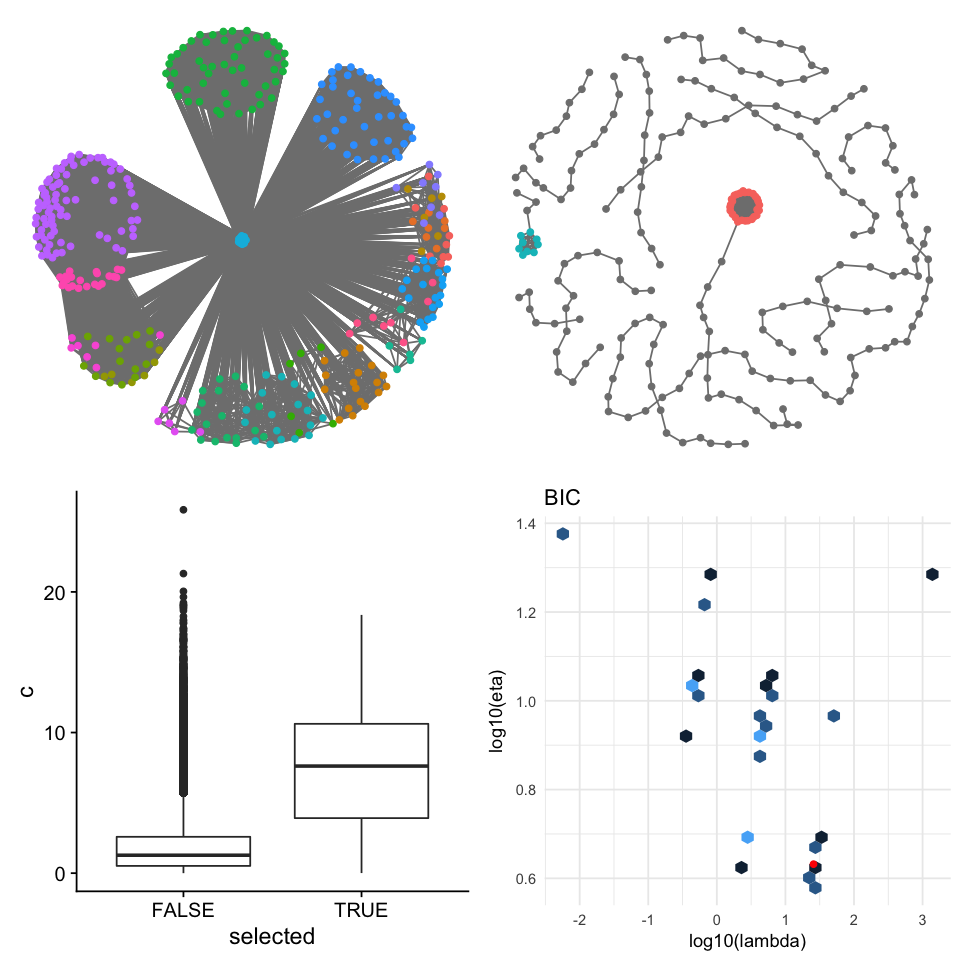

In [13]:
e <- filter(hyper, eta < 10^(0.8) & model_selection == "bic")$experiment[1]
plot_subnets(bic, net, e, "bic")

# AIC

In [14]:
aic <- lapply(experiments, function(e) {
    resfile <- list.files(path = e, pattern = "cones.evo.chi2.aic.*", full.names = T)
    solfile <- list.files(path = e, pattern = "causal.RData", full.names = T)
    load(resfile)
    load(solfile)
    cones$exp <- e
    cones$causal <- causal
    cones
}) %>% do.call(rbind, .)

plotHyper <- filter(hyper, model_selection == "aic") %>%
ggplot(aes(x = log10(lambda), y = log10(eta))) +
    geom_hex() +
    labs(title = "AIC") +
    theme_minimal()

Warning message:
“Removed 4836 rows containing non-finite values (stat_boxplot).”

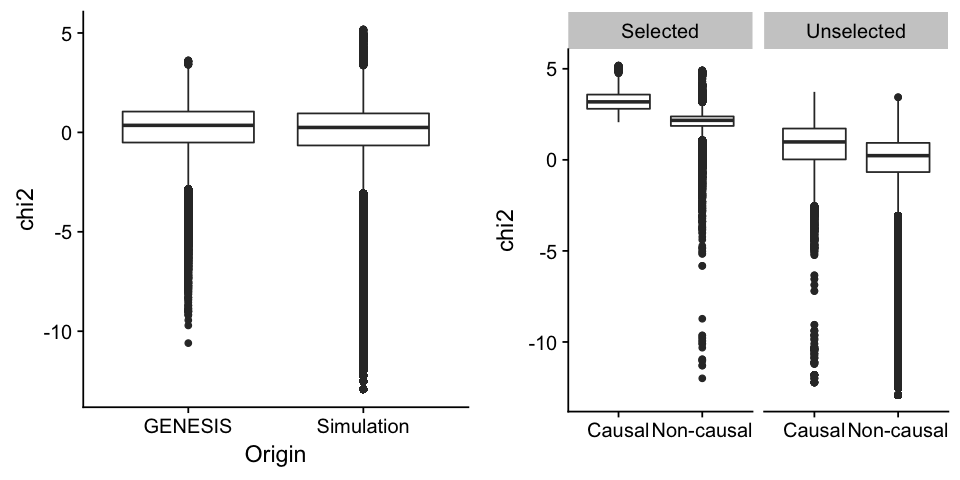

In [15]:
A <- rbind(genesis_results, aic) %>%
    ggplot(aes(x = ifelse(exp == "genesis", "GENESIS", "Simulation"), y = log(c))) + 
        geom_boxplot() +
        labs(x = "Origin", y = "chi2")

B <- ggplot(aic, aes(x = ifelse(causal, "Causal", "Non-causal"), y = log(c))) + 
    geom_boxplot() +
    facet_grid(. ~ ifelse(selected, "Selected", "Unselected")) +
    labs(x = "", y = "chi2")

options(repr.plot.width=8, repr.plot.height=4)
plot_grid(A, B)

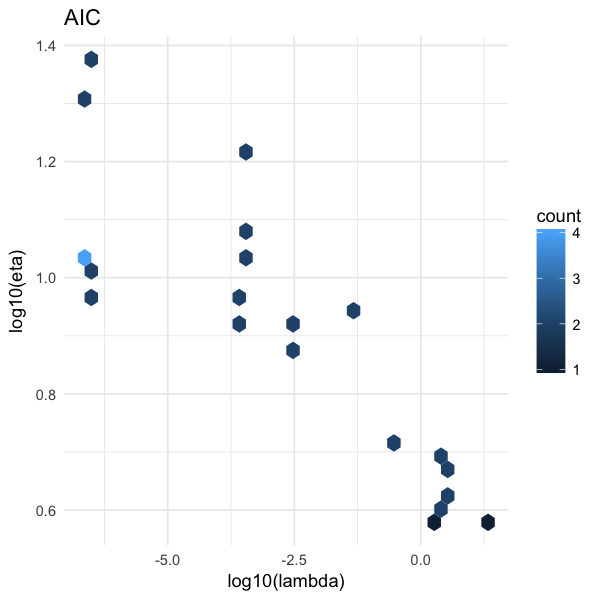

In [16]:
options(repr.plot.width=5, repr.plot.height=5)
plotHyper

# Explore GI network

Check once and for all if the GI network is generated correctly.

In [17]:
library(tidygraph)

# generate a network with only edges corresponding to PPIs
bareGI <- net %>%
    arrange(chr, pos) %>%
    activate(edges) %>%
    # remove GS edges
    filter(from != to - 1) %>%
    # remove GM edges
    filter(.N()$gene[from] != .N()$gene[to])

bareGI

# A tbl_graph: 195920 nodes and 7862918 edges
#
# An undirected simple graph with 122898 components
#
# Edge Data: 7,862,918 x 3 (active)
    from     to weight
   <int>  <int>  <dbl>
1 113489 115832   1.00
2 113484 115832   1.00
3 113487 115832   1.00
4 113455 115832   1.00
5 113460 115832   1.00
6 113466 115832   1.00
# ... with 7.863e+06 more rows
#
# Node Data: 195,920 x 5
    chr     pos gene  nGenes name     
  <int>   <int> <chr>  <dbl> <chr>    
1     1 1018704 <NA>       0 rs9442372
2     1 1062638 <NA>       0 rs9442373
3     1 1094738 <NA>       0 rs4970362
# ... with 1.959e+05 more rows

In [18]:
bareGI %>% activate(nodes) %>% filter(! is.na(gene))

# A tbl_graph: 92348 nodes and 7862918 edges
#
# An undirected simple graph with 19326 components
#
# Node Data: 92,348 x 5 (active)
    chr     pos gene   nGenes name      
  <int>   <int> <chr>   <dbl> <chr>     
1     1 1110019 TTLL10   1.00 rs11260542
2     1 1119858 TTLL10   1.00 rs1320565 
3     1 1156131 SDF4     1.00 rs2887286 
4     1 1162435 SDF4     1.00 rs3766186 
5     1 1983160 PRKCZ    1.00 rs28703783
6     1 1983421 PRKCZ    1.00 rs4648795 
# ... with 9.234e+04 more rows
#
# Edge Data: 7,862,918 x 3
   from    to weight
  <int> <int>  <dbl>
1 52566 53856   1.00
2 52561 53856   1.00
3 52564 53856   1.00
# ... with 7.863e+06 more rows

The network has the same number of edges (7,862,918) if we remove the nodes that are not mapped to any gene.

In [19]:
edges <- as.data.frame(bareGI)
nodes <- as.data.frame(activate(bareGI, nodes)) %>%
    mutate(., nodeid = rownames(.))

# PPIs extracted from bareGI
regions <- merge(edges, nodes, by.x = "from", by.y = "nodeid") %>%
    merge(nodes, by.x = "to", by.y = "nodeid") %>%
    group_by(gene.x, gene.y) %>%
    summarize(chr.x = unique(chr.x), chr.y = unique(chr.y),
              region.begin.x = min(pos.x), region.end.x = max(pos.x),
              region.begin.y = min(pos.y), region.end.y = max(pos.y))
network <- data_frame(key = apply(regions, 1, 
                                  function(x){ 
                                      paste(sort(x[c(1,2)]), collapse = "-")
                                  }), 
                      network = TRUE)
regions$key <- network$key

# PPIs from biogrid
biogrid <- read_tsv("../../data/genesis/BIOGRID-ORGANISM-Homo_sapiens-3.4.138.tab.txt", 
                    col_types = "cccccccciii") %>%
        select(OFFICIAL_SYMBOL_FOR_A, OFFICIAL_SYMBOL_FOR_B) %>%
        apply(1, function(x){ paste(sort(x), collapse = "-")} )
biogrid <- data_frame(key = biogrid, biogrid = TRUE)

Parsed with column specification:
cols(
  INTERACTOR_A = col_character(),
  INTERACTOR_B = col_character(),
  OFFICIAL_SYMBOL_FOR_A = col_character(),
  OFFICIAL_SYMBOL_FOR_B = col_character(),
  ALIASES_FOR_A = col_character(),
  ALIASES_FOR_B = col_character(),
  EXPERIMENTAL_SYSTEM = col_character(),
  SOURCE = col_character(),
  PUBMED_ID = col_integer(),
  ORGANISM_A_ID = col_integer(),
  ORGANISM_B_ID = col_integer()
)


In [20]:
ppis <- merge(network, biogrid, all = TRUE ) %>%
    mutate(biogrid = ifelse(is.na(biogrid), FALSE, biogrid),
           network = ifelse(is.na(network), FALSE, network))

select(ppis, network, biogrid) %>% table

       biogrid
network  FALSE   TRUE
  FALSE      0 252125
  TRUE    7620  73254

There are 7,620 PPIs that are in the network, but not in BioGRID. Let's see how many of them come from an overlapping gene.

In [21]:
filter(ppis, network & ! biogrid)$key %>% grep(".+-.+-", ., value = TRUE) %>% length

[1] 2770

A big share of them correspond to SNPs common to several genes. Let's check one of the cases.

In [22]:
x <- filter(regions, key == 'AMACR-C1QTNF3-AMACR')

net %>%
    activate(nodes) %>%
    filter((chr == x$chr.x & pos >= x$region.begin.x  & pos <= x$region.end.x) |
           (chr == x$chr.y & pos >= x$region.begin.y  & pos <= x$region.end.y)) %>%
    as.data.frame %>%
    arrange(pos)

chr,pos,gene,nGenes,name
5,33989518,AMACR,2,rs2278008
5,33991136,C1QTNF3-AMACR,2,rs3822464
5,33994734,AMACR,2,rs6863657
5,33995705,AMACR,2,rs168803
5,33998768,C1QTNF3-AMACR,2,rs34677
5,33998883,C1QTNF3-AMACR,2,rs2287939
5,33999079,AMACR,2,rs10941110
5,34001855,AMACR,2,rs40601
5,34004707,AMACR,2,rs10941112
5,34007709,AMACR,2,rs34689


There are inconssitencies between the number of genes that appear in `gene` and the number specified in `nGenes`. I will deal with that before further work is done.